##HPK Electricity

This notebook will extract typical profiles for use as input for the coupled co-simulation with CitySim

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline 

In [3]:
workingdir = "/Users/millerc/Dropbox/03-ETH/98-UMEM/RawDataAnalysis/"

In [4]:
# os.chdir(workingdir)

In [5]:
df = pd.read_csv(workingdir+"aggset2_QW/HPK_QW.csv", index_col="Date Time", parse_dates=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70201 entries, 2006-01-07 00:00:00 to 2014-01-10 00:00:00
Data columns (total 10 columns):
HPKMEL01QW_A [kWh]    70169 non-null float64
HPKMEL98QW_A [kWh]    70169 non-null float64
HPKMEL99QW_A [kWh]    70169 non-null float64
HPKMHE01QW_A [kWh]    70169 non-null float64
HPKMHE95QW_A [kWh]    70169 non-null float64
HPKMHE97QW_A [kWh]    70169 non-null float64
HPKMHE99QW_A [kWh]    70169 non-null float64
HPKMKA01QW_A [kWh]    70169 non-null float64
HPKMKA98QW_A [kWh]    70169 non-null float64
HPKMKA99QW_A [kWh]    70169 non-null float64
dtypes: float64(10)
memory usage: 5.9 MB


In [7]:
point = "HPKMKA01QW_A [kWh]"

In [8]:
df_QW = pd.DataFrame(df[point].truncate(before='2013',after='2014'))

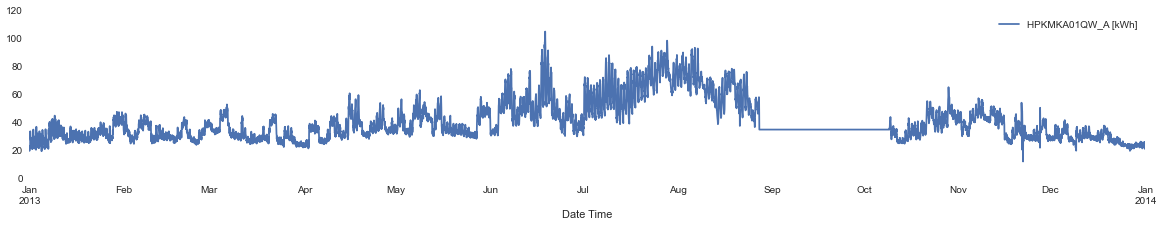

In [9]:
df_QW.plot(figsize=(20,3));

##Convert to SAX

In [10]:
df = df_QW.dropna()

In [11]:
#df.head()

In [12]:
df['Date'] = df.index.map(lambda t: t.date())
df['Time'] = df.index.map(lambda t: t.time())

/Users/millerc/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/millerc/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [13]:
df_pivot = pd.pivot_table(df, values=point, index='Date', columns='Time')

In [14]:
a = 3
w = '4h'

In [15]:
from scipy.stats import norm
import numpy as np
import string

In [16]:
def discretizer(row, breakpoints):
    return np.where(breakpoints > float(row))[0][0]

def stringizer(row):
    return ''.join(string.ascii_letters[int(row['step'])])

def adddate(df):
    df['Date'] = df.index.map(lambda t: t.date())
    df['Time'] = df.index.map(lambda t: t.time())
    return df

def SAXizer(df, symbol_count, breakfreq):
    x = df.fillna(method='ffill')
    y = (x - x.mean()) / x.std()
    z = pd.DataFrame(y.resample(breakfreq).dropna())
    z.columns = ["numbers"]
    breakpoints = norm.ppf(np.linspace(1./symbol_count, 1-1./symbol_count, symbol_count-1))
    breakpoints = np.concatenate((breakpoints, np.array([np.Inf])))
    
    z['step'] = z.apply(discretizer, axis=1, args=[breakpoints])
    z['letter'] = z.apply(stringizer, axis=1)
    z = adddate(z)
    zpivot = z.pivot(index='Date', columns='Time', values='letter')
    zpivot = z.pivot(index='Date', columns='Time', values='letter')
    
    SAXstrings = zpivot.dropna().sum(axis=1)
    
    return zpivot.dropna(), SAXstrings

In [17]:
df_forSAX = df[point]
zpivot, SAXstrings = SAXizer(df_forSAX, a, w)

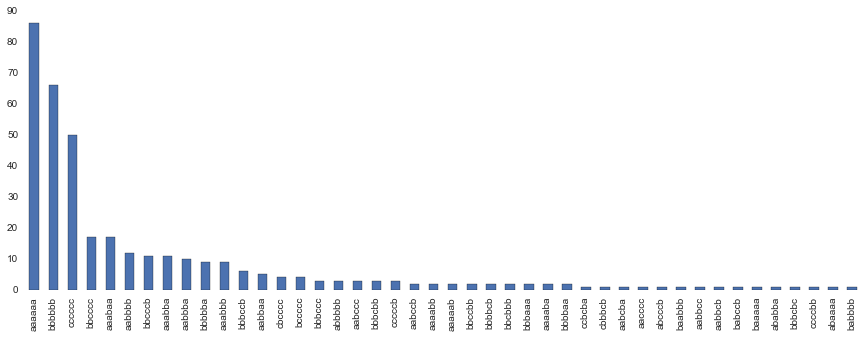

In [18]:
patterncount = SAXstrings.value_counts()
patterncount.plot(kind='bar', figsize=(15,5));

In [19]:
binsizethreshold = 0.02
motifs = patterncount[(patterncount > patterncount.sum() * binsizethreshold)]
motifs

aaaaaa    86
bbbbbb    66
cccccc    50
bbcccc    17
aaabaa    17
aabbbb    12
bbcccb    11
aaabba    11
aabbba    10
bbbbba     9
aaabbb     9
dtype: int64

In [20]:
discords = patterncount[(patterncount < patterncount.sum() * binsizethreshold)]
discords.head()

bbbccb    6
aabbaa    5
cbcccc    4
bccccc    4
bbbccc    3
dtype: int64

In [21]:
df_RawAndSAX = pd.concat([df_pivot, pd.DataFrame(SAXstrings, columns=['SAXstring'])], axis=1)

In [22]:
motifdata = df_RawAndSAX[df_RawAndSAX.SAXstring.isin(list(motifs.index))]

#Cluster!

In [23]:
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt


In [24]:
# df = motifdata.drop(['SAXstring'], axis=1)

In [25]:
df_pivot.head()

Time,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,22.75,19.75,22.75,21.75,23.00,21.50,23.00,33.75,31.50,28.75,...,28.00,27.25,27.75,26.25,27.25,22.75,22.50,23.5,21.00,22.50
2013-01-02,21.75,22.75,21.25,22.75,22.25,22.75,22.00,35.00,30.75,27.00,...,27.50,30.00,28.00,26.75,26.25,22.75,25.25,21.5,23.25,21.25
2013-01-03,21.00,21.75,22.00,22.25,20.50,22.25,21.25,37.00,30.00,29.25,...,27.00,32.00,28.50,31.50,26.00,24.50,25.50,23.0,22.25,24.75
2013-01-04,22.25,21.75,21.75,22.25,22.25,22.00,25.00,33.75,31.50,30.25,...,28.25,32.00,30.75,30.25,30.25,26.75,23.75,23.5,24.50,22.00
2013-01-05,19.50,26.50,22.00,22.25,22.75,21.25,25.75,34.75,30.50,28.75,...,29.75,27.25,28.50,27.75,26.50,24.50,23.50,22.0,22.50,22.25


In [26]:
df = df_pivot

In [27]:
def timestampcombine_parse(date,time):
    #timestampstring = date+" "+time
#     date = datetime.strptime(date, "%Y-%M-%d")
#     time = datetime.strptime(time, "%H:%M:%S").time()
    pydatetime = datetime.combine(date, time)

    #pydatetime = pydatetime.replace(tzinfo=pytz.UTC)
    #return pydatetime.astimezone(singaporezone).replace(tzinfo=None)
    return pydatetime

In [28]:
df = df.T.unstack().reset_index()
df['timestampstring'] = map(timestampcombine_parse, df.Date, df.Time)
df.index = df.timestampstring
df = df.drop(['Date','Time','timestampstring'],axis=1)
df.columns = [point]
df = df.resample('H')

In [29]:
df.head()

,HPKMKA01QW_A [kWh]
timestampstring,
2013-01-01 00:00:00,22.75
2013-01-01 01:00:00,19.75
2013-01-01 02:00:00,22.75
2013-01-01 03:00:00,21.75
2013-01-01 04:00:00,23.00


In [30]:
from scipy.cluster.vq import kmeans, vq, whiten
from scipy.spatial.distance import cdist
from sklearn import metrics
import numpy as np

In [31]:
df_norm = (df - df.mean()) / (df.max() - df.min()) #normalized

df['Time'] = df.index.map(lambda t: t.time())
df['Date'] = df.index.map(lambda t: t.date())
df_norm['Time'] = df_norm.index.map(lambda t: t.time())
df_norm['Date'] = df_norm.index.map(lambda t: t.date())

In [32]:
dailyblocks = pd.pivot_table(df, values=point, index='Date', columns='Time', aggfunc='mean')
dailyblocks_norm = pd.pivot_table(df_norm, values=point, index='Date', columns='Time', aggfunc='mean')

In [33]:
dailyblocksmatrix_norm = np.matrix(dailyblocks_norm.dropna())
centers, _ = kmeans(dailyblocksmatrix_norm, 4, iter=10000)
cluster, _ = vq(dailyblocksmatrix_norm, centers)

In [34]:
clusterdf = pd.DataFrame(cluster, columns=['ClusterNo'])

In [35]:
dailyclusters = pd.concat([dailyblocks.dropna().reset_index(), clusterdf], axis=1) 

In [36]:
x = dailyclusters.groupby('ClusterNo').mean().sum(axis=1).order()
x = pd.DataFrame(x.reset_index())
x['ClusterNo2'] = x.index
x = x.set_index('ClusterNo')
x = x.drop([0], axis=1)
dailyclusters = dailyclusters.merge(x, how='outer', left_on='ClusterNo', right_index=True)

In [37]:
dailyclusters = dailyclusters.drop(['ClusterNo'],axis=1)
dailyclusters = dailyclusters.set_index(['ClusterNo2','Date']).T.sort()

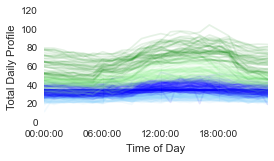

In [38]:
clusterlist = list(dailyclusters.columns.get_level_values(0).unique())
matplotlib.rcParams['figure.figsize'] = 4,2

styles2 = ['LightSkyBlue', 'b','LightGreen', 'g','LightCoral','r','SandyBrown','Orange','Plum','Purple','Gold','b']
fig, ax = plt.subplots()
for col, style in zip(clusterlist, styles2):
    dailyclusters[col].plot(ax=ax, legend=False, style=style, alpha=0.1, xticks=np.arange(0, 86400, 21600))

ax.set_ylabel('Total Daily Profile')
ax.set_xlabel('Time of Day')
plt.savefig("cooling_clusters_total_overlaid_profiles.pdf")

In [39]:
def ClusterUnstacker(df):
    df = df.unstack().reset_index()
    df['timestampstring'] = map(timestampcombine, df.Date, df.level_2)
    df = df.dropna()
    return df

In [40]:
def timestampcombine(date,time):
    pydatetime = datetime.combine(date, time)
    #pydatetime = pydatetime.replace(tzinfo=pytz.UTC)
    #return pydatetime.astimezone(singaporezone).replace(tzinfo=None)
    return pydatetime

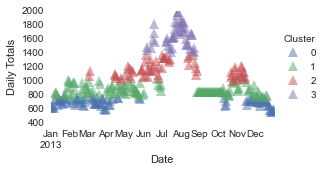

In [41]:
dfclusterunstacked = ClusterUnstacker(dailyclusters)
dfclusterunstackedpivoted = pd.pivot_table(dfclusterunstacked, values=0, index='timestampstring', columns='ClusterNo2')

clusteravgplot = dfclusterunstackedpivoted.resample('D', how=np.sum).plot(style="^",markersize=10, alpha=0.5)
clusteravgplot.set_ylabel('Daily Totals')
clusteravgplot.set_xlabel('Date')
clusteravgplot.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')

plt.savefig("cooling_clusters_overtime.pdf")

In [42]:
dailyclusters.head()

ClusterNo2          0                                                         \
Date       2013-01-01 2013-01-02 2013-01-03 2013-01-04 2013-01-05 2013-01-06   
00:00:00        22.75      21.75      21.00      22.25      19.50      22.75   
01:00:00        19.75      22.75      21.75      21.75      26.50      21.00   
02:00:00        22.75      21.25      22.00      21.75      22.00      22.75   
03:00:00        21.75      22.75      22.25      22.25      22.25      24.25   
04:00:00        23.00      22.25      20.50      22.25      22.75      22.00   

ClusterNo2                                                ...              3  \
Date       2013-01-07 2013-01-12 2013-01-13 2013-01-14    ...     2013-08-10   
00:00:00        23.50      30.50      24.75      25.75    ...         60.125   
01:00:00        21.75      27.50      26.75      27.50    ...         58.625   
02:00:00        22.75      31.50      27.50      25.75    ...         58.000   
03:00:00        21.50      31.00      25.50      26.00    ...         58.750   
04:00:00        23.00      29.25      27.50      27.50    ...         56.875   

ClusterNo2                                                                    \
Date       2013-08-11 2013-08-12 2013-08-16 2013-08-17 2013-08-18 2013-08-19   
00:00:00       62.375     62.125     52.875     65.000     64.875     71.625   
01:00:00       60.250     62.250     51.875     64.500     65.125     72.500   
02:00:00       58.875     60.500     49.750     65.625     66.125     72.375   
03:00:00       58.125     60.625     49.000     63.500     66.625     71.625   
04:00:00       57.875     57.750     47.375     60.250     65.000     68.500   

ClusterNo2                                   
Date       2013-08-20 2013-08-22 2013-08-23  
00:00:00       56.875     50.125     60.125  
01:00:00       54.625     47.750     58.500  
02:00:00       54.750     47.375     55.500  
03:00:00       53.875     46.750     50.625  
04:00:00       52.375     45.500     51.500  

[5 rows x 364 columns]

In [43]:
calendar = dfclusterunstackedpivoted.resample('D', how=np.sum)
calendar.head()

ClusterNo2,0,1,2,3
timestampstring,,,,
2013-01-01,610.50,NaN,NaN,NaN
2013-01-02,612.25,NaN,NaN,NaN
2013-01-03,633.00,NaN,NaN,NaN
2013-01-04,649.75,NaN,NaN,NaN
2013-01-05,623.25,NaN,NaN,NaN


In [44]:
calendar.to_csv("cooling_calendar.csv")

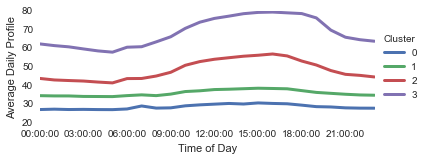

In [45]:
dfclusterunstackedpivoted['Time'] = dfclusterunstackedpivoted.index.map(lambda t: t.time())
dailyprofile = dfclusterunstackedpivoted.groupby('Time').mean().plot(figsize=(6,2),linewidth=3, xticks=np.arange(0, 86400, 10800))
dailyprofile.set_ylabel('Average Daily Profile')
dailyprofile.set_xlabel('Time of Day')
dailyprofile.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')
plt.savefig("cooling_clusters_averagedprofiles.pdf")

In [46]:
dfclusterunstackedpivoted.groupby('Time').max().max().max()

105.24999999138529

In [47]:
#dfclusterunstackedpivoted['Time'] = dfclusterunstackedpivoted.index.map(lambda t: t.time())
normalizedprofiles = dfclusterunstackedpivoted.groupby('Time').mean() / dfclusterunstackedpivoted.groupby('Time').max().max().max()

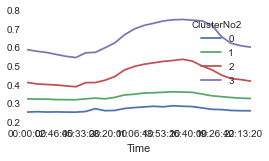

In [48]:
normalizedprofiles = normalizedprofiles.fillna(0)
normalizedprofiles.plot()

In [49]:
normalizedprofiles.to_csv("cooling_Schedules.csv")

In [50]:
def DayvsClusterMaker(df):
    df.index = df.timestampstring
    df['Weekday'] = df.index.map(lambda t: t.date().weekday())
    df['Date'] = df.index.map(lambda t: t.date())
    df['Time'] = df.index.map(lambda t: t.time())
    DayVsCluster = df.resample('D').reset_index(drop=True)
    DayVsCluster = pd.pivot_table(DayVsCluster, values=0, index='ClusterNo2', columns='Weekday', aggfunc='count')
    DayVsCluster.columns = ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']
    return DayVsCluster.T

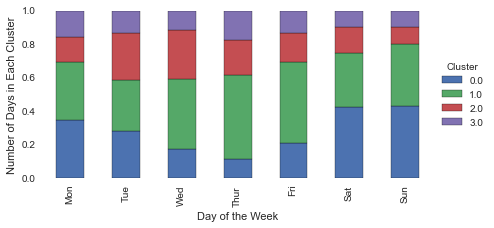

In [51]:
DayVsCluster = DayvsClusterMaker(dfclusterunstacked)
DayVsCluster = DayVsCluster.T/DayVsCluster.T.sum()
DayVsCluster = DayVsCluster.T
DayVsClusterplot1 = DayVsCluster.plot(figsize=(7,3), kind='bar', stacked=True)
DayVsClusterplot1.set_ylabel('Number of Days in Each Cluster')
DayVsClusterplot1.set_xlabel('Day of the Week')
DayVsClusterplot1.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')
plt.savefig("cooling_clusters_dailybreakdown.pdf")

In [107]:
DayVsCluster

ClusterNo2,0.0,1.0,2.0,3.0
Mon,0.076923,0.519231,0.326923,0.076923
Tue,0.056604,0.245283,0.471698,0.226415
Wed,0.057692,0.173077,0.403846,0.365385
Thur,0.076923,0.250000,0.326923,0.346154
Fri,0.057692,0.442308,0.326923,0.173077
Sat,0.884615,0.096154,0.019231,NaN
Sun,0.901961,0.078431,0.019608,NaN


##Create Graphics for JBPS Paper

First load the resultant data from the analysis so no need to rerun:

In [108]:
normalizedprofiles = pd.read_csv("Schedules.csv", index_col='Time')

In [109]:
normalizedprofiles.head()

,0,1,2,3
Time,,,,
00:00:00,0.499424,0.524297,0.566745,0.665788
01:00:00,0.496599,0.521304,0.563211,0.659900
02:00:00,0.496506,0.515506,0.560267,0.659675
03:00:00,0.495314,0.515452,0.557847,0.656670
04:00:00,0.496105,0.516557,0.557668,0.653359


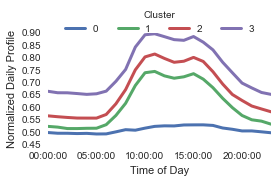

In [111]:
dailyprofile = normalizedprofiles.plot(figsize=(4,2),linewidth=3)
dailyprofile.set_ylabel('Normalized Daily Profile')
dailyprofile.set_xlabel('Time of Day')
dailyprofile.legend(loc='center', bbox_to_anchor=(0.5, 1.1), title='Cluster', ncol=4)
plt.savefig("clusters_averagedprofiles_normalized.pdf")

###The Cal-Heatmap setup

In [112]:
calendar = pd.read_csv("calendar.csv", index_col='timestampstring', parse_dates=True)

In [113]:
#calendar.fillna(0).dropna(how="all").info()

In [114]:
import time

In [115]:
calendar['epochtime'] = calendar.index.map(lambda x: int(time.mktime(x.timetuple())))
calendar.index = calendar.epochtime

In [116]:
calendar.head()

,0,1,2,3,epochtime
epochtime,,,,,
1356994800,1010.25,NaN,NaN,NaN,1356994800
1357081200,1033.75,NaN,NaN,NaN,1357081200
1357167600,1161.00,NaN,NaN,NaN,1357167600
1357254000,1152.25,NaN,NaN,NaN,1357254000
1357340400,1057.00,NaN,NaN,NaN,1357340400


In [117]:
calendar = calendar.drop(['epochtime'], axis=1)

In [118]:
calendar.head()

,0,1,2,3
epochtime,,,,
1356994800,1010.25,NaN,NaN,NaN
1357081200,1033.75,NaN,NaN,NaN
1357167600,1161.00,NaN,NaN,NaN
1357254000,1152.25,NaN,NaN,NaN
1357340400,1057.00,NaN,NaN,NaN


In [119]:
cal_heatmap = calendar.unstack().dropna().reset_index()

In [120]:
cal_heatmap.head()

,level_0,epochtime,0
0,0,1356994800,1010.25
1,0,1357081200,1033.75
2,0,1357167600,1161.00
3,0,1357254000,1152.25
4,0,1357340400,1057.00


In [121]:
cal_heatmap.index = cal_heatmap.epochtime

In [122]:
cal_heatmap.head()

,level_0,epochtime,0
epochtime,,,
1356994800,0,1356994800,1010.25
1357081200,0,1357081200,1033.75
1357167600,0,1357167600,1161.00
1357254000,0,1357254000,1152.25
1357340400,0,1357340400,1057.00


In [123]:
cal_heatmap = cal_heatmap.drop(['epochtime',0], axis=1)

In [124]:
cal_heatmap = cal_heatmap.sort()

In [125]:
cal_heatmap.level_0 = cal_heatmap.level_0.astype("float")

In [126]:
cal_heatmap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364 entries, 1356994800 to 1388444400
Data columns (total 1 columns):
level_0    364 non-null float64
dtypes: float64(1)
memory usage: 5.7 KB


In [127]:
cal_heatmap.head()

,level_0
epochtime,
1356994800,0
1357081200,0
1357167600,0
1357254000,0
1357340400,0


In [128]:
cal_heatmap = cal_heatmap+1

In [129]:
cal_heatmap.head()

,level_0
epochtime,
1356994800,1
1357081200,1
1357167600,1
1357254000,1
1357340400,1


In [134]:
cal_heatmap.level_0.to_json("hpk_cal_heatmap.json")

In [131]:
x = sns.color_palette()

In [132]:
import matplotlib.colors as colors

In [133]:
for color in x:
    print colors.rgb2hex(color)

#4c72b0
#55a868
#c44e52
#8172b2
#ccb974
#64b5cd
